<a href="https://colab.research.google.com/github/eunShim/BigDataCapstone/blob/main/bigdatacapstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CSV 파일 개수: 297915
샘플 데이터 크기: (214783, 8)
       timestamp   action_type item_id  cursor_time     source user_answer  \
0  1540729473505         enter   b2421          NaN  diagnosis         NaN   
1  1540729499537  erase_choice   q3889          NaN  diagnosis           d   
2  1540729511674       respond   q3889          NaN  diagnosis           c   
3  1540729513458  erase_choice   q3889          NaN  diagnosis           b   
4  1540729514290       respond   q3889          NaN  diagnosis           a   

  platform  user_id  
0      web  u297833  
1      web  u297833  
2      web  u297833  
3      web  u297833  
4      web  u297833  

[Action Type 분포]
action_type
enter                0.273555
respond              0.177677
quit                 0.138847
submit               0.134708
pause_audio          0.101009
play_audio           0.099924
erase_choice         0.041349
play_video           0.016091
pause_video          0.015821
undo_erase_choice    0.000773
pay                  0.00023

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


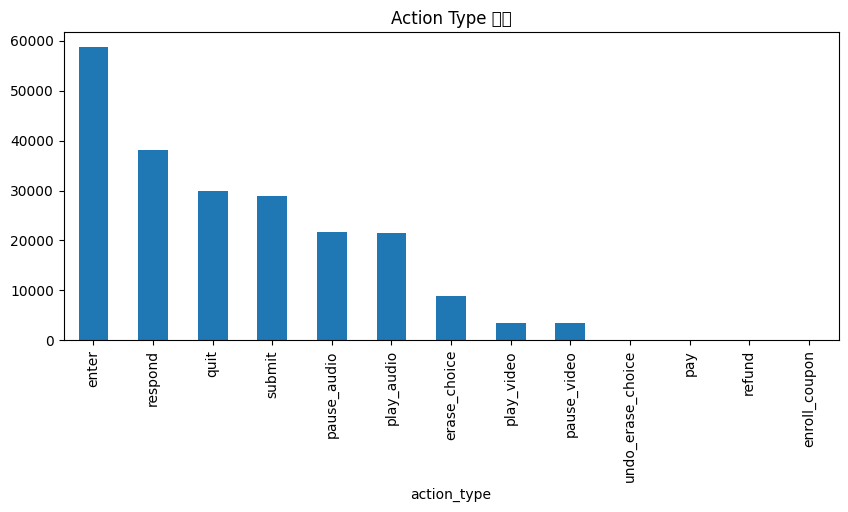


[Platform 분포]
platform
mobile    0.752666
web       0.247334
Name: proportion, dtype: float64


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


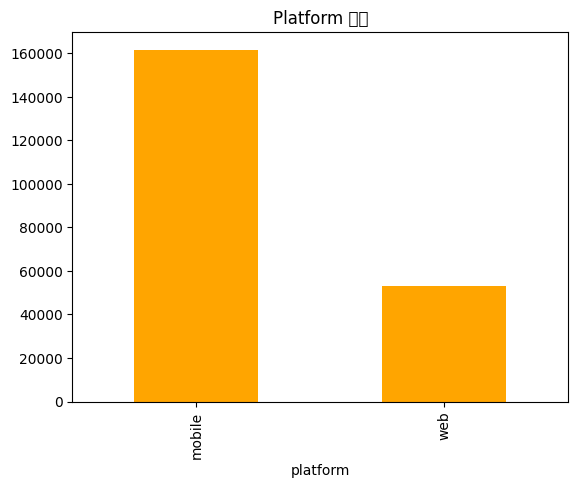


[Submit 로그 예시]
    user_id item_id user_answer
16  u297833   b2421         NaN
20  u297833   b5064         NaN
23  u297833   b5015         NaN
26  u297833   b4700         NaN
33  u297833    b380         NaN

[Cursor Time 기초통계]
count    5.001100e+04
mean     2.502669e+04
std      5.539930e+04
min      0.000000e+00
25%      0.000000e+00
50%      1.058100e+04
75%      1.891200e+04
max      1.041995e+06
Name: cursor_time, dtype: float64


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


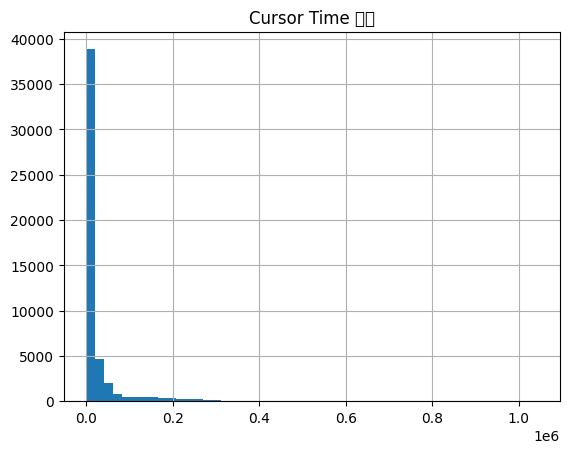


[Source 분포]
source
sprint            151132
review_quiz        15787
adaptive_offer     15117
my_note            12915
diagnosis          10372
archive             4803
tutor               3839
review               765
Name: count, dtype: int64

[사용자별 요약 통계]
       total_actions  unique_items   platforms
count     408.000000    408.000000  408.000000
mean      526.428922    185.051471    1.044118
std      2681.672467    831.918687    0.205609
min         3.000000      2.000000    1.000000
25%        22.000000     12.000000    1.000000
50%        31.000000     16.000000    1.000000
75%       151.250000     56.500000    1.000000
max     40871.000000  11779.000000    2.000000


In [16]:
import zipfile
import random
import pandas as pd
import matplotlib.pyplot as plt

# =======================================
# 1. ZIP 내부 파일 읽기
# =======================================
zip_path = "/content/EdNet-KT4.zip"
zf = zipfile.ZipFile(zip_path)

# CSV 파일 리스트 (폴더 제외)
file_list = [f for f in zf.namelist() if f.endswith(".csv") and not f.endswith("/")]
print("CSV 파일 개수:", len(file_list))

# --------------------------
# 2. 무작위 500명 샘플링
# --------------------------
sample_files = random.sample(file_list, 500)

dfs = []
for f in sample_files:
    try:
        with zf.open(f) as fp:
            df = pd.read_csv(fp)
            df["user_id"] = f.split("/")[-1].replace(".csv","")
            dfs.append(df)
    except Exception:
        # 손상 파일은 그냥 무시 (출력 X)
        continue

# 전체 합치기
data = pd.concat(dfs, ignore_index=True)
print("샘플 데이터 크기:", data.shape)
print(data.head())

# --------------------------
# 3. 변수별 경향성 분석
# --------------------------

# (1) action_type 분포
print("\n[Action Type 분포]")
print(data["action_type"].value_counts(normalize=True))

data["action_type"].value_counts().plot(kind="bar", figsize=(10,4))
plt.title("Action Type 분포")
plt.show()

# (2) 플랫폼 분포
print("\n[Platform 분포]")
print(data["platform"].value_counts(normalize=True))

data["platform"].value_counts().plot(kind="bar", color="orange")
plt.title("Platform 분포")
plt.show()

# (3) 제출 로그만 확인 (submit)
submit_logs = data[data["action_type"]=="submit"].copy()
print("\n[Submit 로그 예시]")
print(submit_logs[["user_id","item_id","user_answer"]].head())

# (4) cursor_time (비디오/오디오 행동)
cursor_df = data[data["cursor_time"].notnull() & (data["cursor_time"]!="-")].copy()
cursor_df.loc[:, "cursor_time"] = pd.to_numeric(cursor_df["cursor_time"], errors="coerce")
print("\n[Cursor Time 기초통계]")
print(cursor_df["cursor_time"].describe())

cursor_df["cursor_time"].hist(bins=50)
plt.title("Cursor Time 분포")
plt.show()

# (5) source 분포
print("\n[Source 분포]")
print(data["source"].value_counts().head(20))

# --------------------------
# 4. 사용자별 기본 통계
# --------------------------
user_stats = data.groupby("user_id").agg(
    total_actions=("action_type","count"),
    unique_items=("item_id","nunique"),
    platforms=("platform","nunique")
)
print("\n[사용자별 요약 통계]")
print(user_stats.describe())
